In [54]:
!pip install shapely

You should consider upgrading via the '/home/amor/Documents/code_dw/neural-styles/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pydiffvg

path1 = "/home/amor/Documents/code_dw/neural-styles/images/polygon_neural_style/result_filled_n_paths200_" \
    "im_size224_n_steps500_layer_nameVGG16Layers.Conv4_3_layer_index46.svg"

path2 = "/home/amor/Documents/code_dw/neural-styles/deps/LIVE-Layerwise-Image-Vectorization/LIVE/log/166022352692_neural_style_test_128_2/output-svg/4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4.svg"

path3 = "/home/amor/Documents/code_dw/neural-styles/deps/LIVE-Layerwise-Image-Vectorization/LIVE/log/166074017552_robot_love/output-svg/4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4-4.svg"

path4 = "/home/amor/Documents/code_dw/neural-styles/images/svg_neur_exc/result_n_paths202_im_size500_n_steps2500_layer_nameVGGLayers.Conv5_3_layer_index11.svg"

svg = path4
canvas_width, canvas_height, shapes, shape_groups = \
    pydiffvg.svg_to_scene(svg)

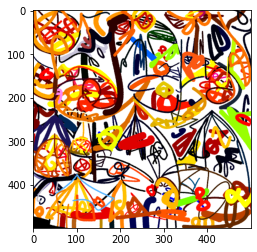

In [3]:
import torch
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2hsv, hsv2rgb, rgb2lab, lab2rgb
import numpy as np



def my_render(shapes, shape_groups, ax=None, size=(500, 500)):
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene( \
        1 * size[0], 1 * size[1], shapes, shape_groups)
    img = render(1 * size[0], 1 * size[1], 2, 2, 0,
                 torch.ones((1 * size[1], 1 * size[0], 4)), *scene_args)
    if ax is None:
        plt.imshow(img.cpu().detach().numpy())
    else:
        ax.imshow(img.cpu().detach().numpy())

my_render(shapes, shape_groups)

In [23]:
shapes[0].__dict__

{'num_control_points': tensor([2, 2, 2]),
 'points': tensor([[214.6179, 322.2415],
         [217.7642, 356.3009],
         [228.5791, 285.1013],
         [200.6692, 286.7252],
         [167.2348, 320.4822],
         [217.6526, 350.0959],
         [224.9432, 272.1813],
         [223.2295, 199.9293],
         [327.1199, 338.0522],
         [288.4062, 315.3906]]),
 'is_closed': False,
 'stroke_width': tensor(1.8120),
 'id': '',
 'use_distance_approx': False,
 'source_id': ''}

In [25]:
shape_groups[0].__dict__

{'shape_ids': tensor([0]),
 'fill_color': None,
 'use_even_odd_rule': False,
 'stroke_color': tensor([0.0000, 0.0000, 0.0980, 1.0000]),
 'shape_to_canvas': tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
 'id': ''}

-153.76472230786692


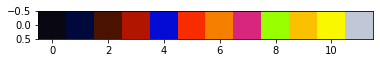

In [5]:
from shapely.geometry import Point, Polygon 

polys = [Polygon(s.points) for s in new_shapes]


X = [rgb2lab(sg.stroke_color.detach().numpy()[:3] * sg.stroke_color.detach().numpy()[3]) for sg in new_shape_groups]
W = [poly.area for poly in polys]


kmeans = KMeans(n_clusters=12, random_state=0, max_iter=1000)
kmeans.fit(X, sample_weight=W)
predicted_kmeans = kmeans.predict(X, sample_weight=W)
print(kmeans.score(X, sample_weight=W) / np.sum(W))

def display_colors(X):
    n_centers, _ = X.shape
    rgb_X = sorted([lab2rgb(X[i, :]) for i in range(n_centers)], key=lambda x: np.sum(x))
    XX = np.concatenate(rgb_X, axis=-1).reshape(-1, 3)
    plt.imshow(XX.reshape(1, -1, 3))
    
display_colors(kmeans.cluster_centers_)

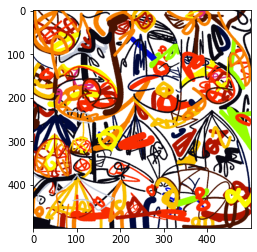

In [8]:


new_colors = [lab2rgb(kmeans.cluster_centers_[i]) for i in predicted_kmeans]

new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), stroke_color=torch.tensor((*new_colors[i], 1)), fill_color=None,
                               ) 
           for i, sg in enumerate(new_shape_groups)]

my_render(new_shapes, new_sgs)

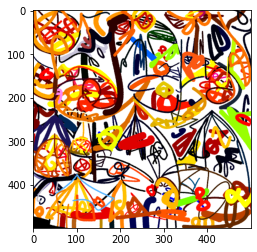

In [18]:
my_render(shapes, shape_groups)


In [19]:
pydiffvg.save_svg("./quantized_color_rendering.svg", 500, 500, new_shapes, new_sgs)

In [20]:
import random

def ransac_kmeans(X, W=None, n_clusters=4, trials=50):
    results = list()
    if W is None:
        W = [1 for w in range(len(X))]
    W_normalized = [w / np.sum(W) for w in W]
        
    
    for i in range(trials):
        n_pts = len(X)
        n_sampled = random.randint(int(6 * n_pts / 7), n_pts)
        indices = np.random.choice(range(n_pts), n_sampled, replace=False, p=W_normalized)
        X_sampled = [X[i] for i in indices]
        W_sampled = [W[i] for i in indices]
        
        ckmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
        ckmeans.fit(X_sampled, sample_weight=W_sampled)
        results.append((ckmeans, ckmeans.score(X_sampled, sample_weight=W_sampled) / np.sum(W_sampled), n_sampled))
    
    # The score is the negative of the sum of distance to each center
    best_res = sorted(results, key=lambda x: x[1], reverse=True)[0]
    print("Best score : ", best_res[1], " ", best_res[2])
    predicted_kmeans = best_res[0].predict(X, sample_weight=W)
    return best_res[0], predicted_kmeans
    
    

Best score :  -409.4948382838015   188
-452.7963234337098


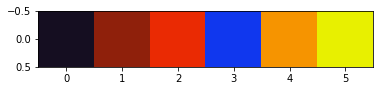

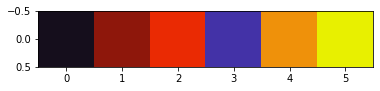

In [34]:

X = [rgb2lab(sg.stroke_color.detach().numpy()[:3] * sg.stroke_color.detach().numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - sg.stroke_color.numpy()[3]))) 
     for sg in shape_groups]
W = [float(s.stroke_width) for s in shapes]
total_W = sum(W)
W_normalised = [w / total_W for w in W]
n_colors = 6


r_kmeans, r_predicted_kmeans = ransac_kmeans(X, W_normalised, n_colors)
display_colors(r_kmeans.cluster_centers_)


r_new_colors = [lab2rgb(r_kmeans.cluster_centers_[i]) for i in r_predicted_kmeans]
r_new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), stroke_color=torch.tensor((*r_new_colors[i], 1)), fill_color=None
                               ) 
           for i, sg in enumerate(shape_groups)]

kmeans = KMeans(n_clusters=n_colors, random_state=0, max_iter=1000)
kmeans.fit(X, sample_weight=W_normalised)
predicted_kmeans = kmeans.predict(X, sample_weight=W_normalised)
print(kmeans.score(X, sample_weight=W) / np.sum(W))

def display_colors(X):
    n_centers, _ = X.shape
    rgb_X = sorted([lab2rgb(X[i, :]) for i in range(n_centers)], key=lambda x: np.sum(x))
    XX = np.concatenate(rgb_X, axis=-1).reshape(-1, 3)
    plt.imshow(XX.reshape(1, -1, 3))
    
plt.figure()
display_colors(kmeans.cluster_centers_)



new_colors = [lab2rgb(kmeans.cluster_centers_[i]) for i in predicted_kmeans]
new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), stroke_color=torch.tensor((*new_colors[i], 1)), fill_color=None
                               ) 
           for i, sg in enumerate(shape_groups)]




Text(0.5, 1.0, 'Ransac sampling')

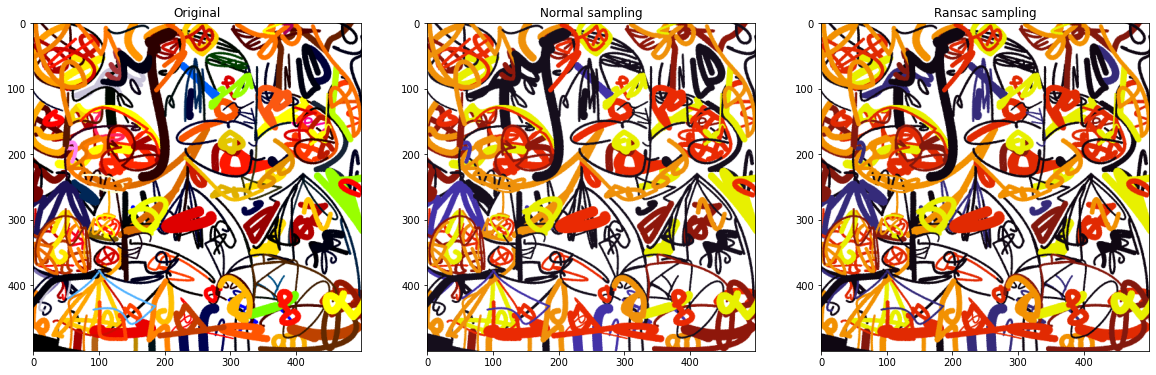

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
my_render(new_shapes, new_sgs, axes[1])
axes[1].set_title("Normal sampling")
my_render(new_shapes, r_new_sgs, axes[2])
axes[2].set_title("Ransac sampling")

/home/amor/Documents/code_dw/neural-styles/venv/lib/python3.8/site-packages/diffvg-0.0.1-py3.8-linux-x86_64.egg/pydiffvg/render_pytorch.py:136: Warning: Detected non-closed paths with fill color. This might causes unexpected results.
  warnings.warn("Detected non-closed paths with fill color. This might causes unexpected results.", Warning)


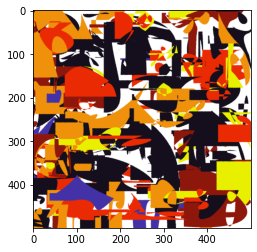

In [32]:

new_colors = [lab2rgb(kmeans.cluster_centers_[i]) for i in predicted_kmeans]

new_sgs = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), fill_color=torch.tensor((*new_colors[i], 1)),
                               ) 
           for i, sg in enumerate(new_shape_groups)]

my_render(new_shapes, new_sgs)

In [66]:
## Stroke quantization

In [35]:
color_indices = [[i for i in range(len(predicted_kmeans)) if predicted_kmeans[i] == k] for k in range(n_colors)]


In [36]:
color_stroke_width = list()

for color_index in color_indices:
    X_sampled = np.array([float(W[i]) for i in color_index]).reshape((-1, 1))
    fake_W = np.ones_like(X_sampled).reshape(-1)
    stroke_kmeans, _ = ransac_kmeans(X_sampled, fake_W, 1)
    color_stroke_width.append(stroke_kmeans.cluster_centers_[0])
    
color_stroke_width

Best score :  -1.8625924157852958   34
Best score :  -1.6317959920077048   72
Best score :  -2.3041554888528326   19
Best score :  -0.943411960644604   26
Best score :  -0.8531505791569243   8
Best score :  -2.305247031123982   23


[array([3.2848305]),
 array([2.29890776]),
 array([4.02156184]),
 array([3.47705764]),
 array([2.47941022]),
 array([3.37053264])]

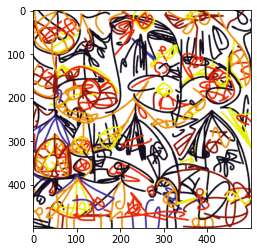

In [37]:
predicted_kmeans = stroke_kmeans.predict(np.array(W).reshape((-1, 1)))

stroke_array = [2 * int(w / 2) for w in color_stroke_width]
new_new_shapes = list()

#new_shapes, new_sgs
for i in range(len(new_sgs)):
    shape = new_shapes[i]
    color_index = predicted_kmeans[i]
    new_new_shapes.append(pydiffvg.Path(num_control_points=shape.num_control_points, 
                                        points=shape.points,
                                        stroke_width=torch.tensor(stroke_array[color_index]), 
                                        is_closed=False))





Text(0.5, 1.0, 'Color and stroke quantization')

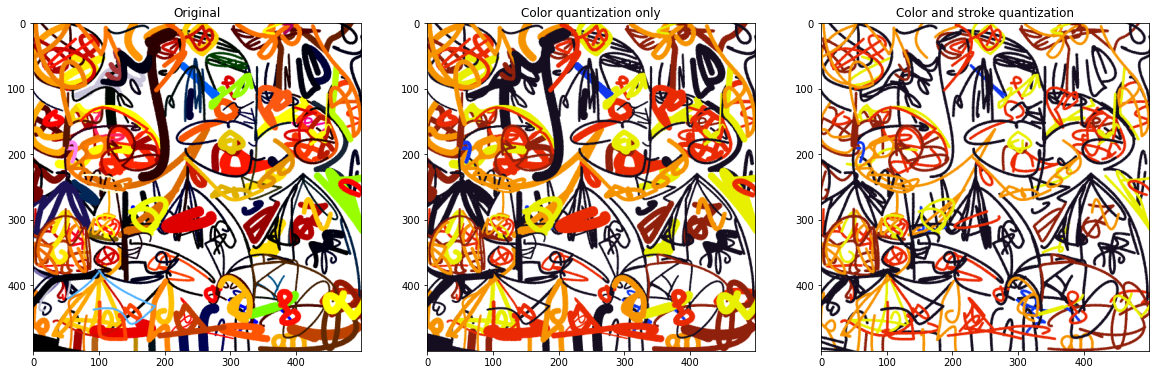

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

my_render(shapes, shape_groups, axes[0])
axes[0].set_title("Original")
my_render(new_shapes, r_new_sgs, axes[1])
axes[1].set_title("Color quantization only")
my_render(new_new_shapes, r_new_sgs, axes[2])
axes[2].set_title("Color and stroke quantization")

In [71]:
pydiffvg.save_svg("./quantized_color_and_stroke_rendering.svg", 500, 500, new_new_shapes, new_sgs)

In [72]:
# 3 - quantization using cover of the image

def get_pixel_values(shapes, shape_groups, size=224):
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene( \
        1 * size, 1 * size, shapes, shape_groups)
    img = render(1 * size, 1 * size, 2, 2, 0,
                 torch.ones((1 * size, 1 * size, 4)), *scene_args)
    return img.reshape((-1, 4))

X = get_pixel_values(shapes, shape_groups)
X.shape

torch.Size([50176, 4])

In [73]:
Xs = X.cpu()[:, :3] * X.cpu()[:, 3:]
#Xlab = 

kmeans = KMeans(n_clusters=12, random_state=0, max_iter=1000)
kmeans.fit(rgb2lab(Xs.numpy().astype('float')), sample_weight=None)


KMeans(max_iter=1000, n_clusters=12, random_state=0)

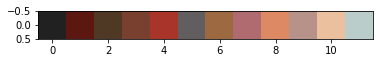

In [74]:

display_colors(kmeans.cluster_centers_)

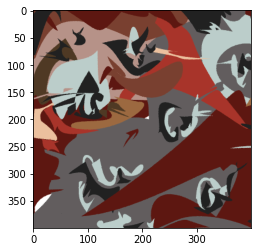

In [75]:
colors = [rgb2lab(sg.fill_color[:3] * sg.fill_color[3:]) for sg in shape_groups]
predicted_index = kmeans.predict(colors)

new_sgs_v2 = [pydiffvg.ShapeGroup(shape_ids=torch.tensor([i]), 
                               fill_color=torch.tensor((*lab2rgb(kmeans.cluster_centers_[predicted_index[i]]), 1)),
                               ) 
              for i, sg in enumerate(shape_groups)]

my_render(shapes, new_sgs_v2)

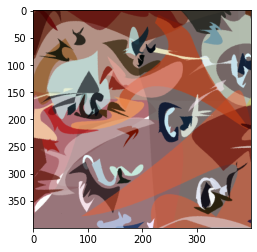

In [76]:
my_render(shapes, shape_groups)


In [77]:
# 4 - Use inter region as unit basis

In [78]:
import pydiffvg
import bezier
from shapely.geometry import Polygon, Point, LineString
from typing import NamedTuple, Tuple, List
from shapely.validation import make_valid
from collections import defaultdict


def alpha_color_over(a, b):
    alpha_a, alpha_b = a[3], b[3]
    alpha_z = alpha_a + alpha_b * (1.0 - alpha_a)
    c_a, c_b = a[:3], b[:3]
    c_z = (c_a * alpha_a + c_b * alpha_b * (1.0 - alpha_a)) / alpha_z
    return torch.tensor((*c_z.numpy().tolist(), alpha_z))


class Geometry(NamedTuple):
    index: int
    poly: List[bezier.curve.Curve]
    color: Tuple[float, float, float, float]
        
    @classmethod
    def from_diffvg(cls, s, sg):
        curves = list()
        index = 0
        ctrl_pts = s.num_control_points.numpy().tolist()
        shape_pts = s.points.numpy().tolist()
        shape_pts = shape_pts + shape_pts[:1]
        for k in ctrl_pts:
            pts = shape_pts[index: index + k + 2]
            xs, ys = zip(*pts)
            curves.append(bezier.curve.Curve([xs, ys], k + 1))
            index += k + 1
        return cls(sg.shape_ids, curves, sg.fill_color)
    
    def plot(self):
        print([s.nodes for s in self.poly])
        bezier.curved_polygon.CurvedPolygon(*self.poly).plot()
    
    def to_polygon(self):
        n_ctrl_pts = len(self.poly)
        pts = list()
        for i in range(n_ctrl_pts):
            xs, ys = self.poly[i].evaluate_multi(np.linspace(0.0, 1.0, 10))
            pts.extend(zip(xs, ys))
        return Polygon(pts)
    
    def to_valid_polygons(self):
        poly = self.to_polygon()
        geom = make_valid(poly)
        
        try:
            return list(geom.geoms)
        except AttributeError:
            return [geom]
                
        
    def to_diffvg(self):
        n_ctrl_pts = len(self.poly)
        pts = list()
        for i in range(n_ctrl_pts):
            xs, ys = self.poly[i].nodes
            pts.extend(list(zip(xs, ys))[:-1])
        return pydiffvg.Path(num_control_points=torch.zeros(n_ctrl_pts) + 2, 
                             points=torch.tensor(pts, dtype=torch.float32),
                         stroke_width=torch.tensor(0.0), is_closed=True), \
               pydiffvg.ShapeGroup(shape_ids=torch.tensor([self.index]), fill_color=torch.tensor(self.color), 
                                  stroke_color=self.color, use_even_odd_rule=False)

    @classmethod
    def render(cls, geoms):
        shapes, shape_groups = list(), list()
        for g in geoms:
            s, sg  = g.to_diffvg()
            shapes.append(s)
            shape_groups.append(sg)
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups)
        
    @classmethod
    def poly_render(cls, geoms):
        shapes, shape_groups = list(), list()
        index = 0
        for g in geoms:
            _, sg  = g.to_diffvg()
            for p in g.to_valid_polygons():
                s = pydiffvg.Polygon(points=torch.tensor(p.exterior.coords),
                                     stroke_width=torch.tensor(0.0), is_closed=True)
                shapes.append(s)
                sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=sg.fill_color, 
                                         stroke_color=sg.fill_color, use_even_odd_rule=False)
                shape_groups.append(sg)
                index += 1
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups)
        
    @classmethod
    def to_color_poly(cls, geoms):
        color_polys = list()
        index = 0
        for g in geoms:
            for p in g.to_valid_polygons():
                color_polys.append(ColorPoly(g.index, p, g.color))
        return color_polys
    
    
class ColorPoly(NamedTuple):
    index: int
    shape: Polygon
    color: Tuple[int, int, int, int]
        
    @classmethod
    def to_chunks(cls, color_polys):
        chunks = list()
        
        for i in range(len(color_polygons)):
            a = color_polygons[i].shape
            current_intersections = list()
            
            # a - compute intersections with other polys
            for j in range(i + 1, len(color_polygons)):

                b = color_polygons[j].shape

                c = a.intersection(b)
                if c.is_empty or type(c) in [LineString, Point]:
                    continue
                blend = alpha_color_over(color_polys[i].color, color_polys[j].color)
                try:
                    for element in c.geoms:
                        new_element = ColorPoly(j+1, element, blend)
                        current_intersections.append(new_element)

                except AttributeError:
                    new_element = ColorPoly(j+1, c, blend)
                    current_intersections.append(new_element)

            chunks.extend(current_intersections)
            
            # b - add the main shape minus intersections
            remaining = a
            
            for intersection in current_intersections:
                remaining = remaining.difference(intersection.shape)
                
            try:
                for element in remaining.geoms:
                    if element.is_empty or type(element) in [LineString, Point]:
                        continue
                    chunks.append(ColorPoly(i, element, color_polygons[i].color))
            except AttributeError:
                chunks.append(ColorPoly(i, remaining, color_polygons[i].color))
        return chunks
    
    @classmethod
    def render(cls, color_polys, ax=None):
        shapes, shape_groups = list(), list()
        index = 0
        for cp in sorted(color_polys, key=lambda x: x.index):
            if cp.shape.is_empty or type(cp.shape) in [Point, LineString]:
                continue
            s = pydiffvg.Polygon(points=torch.tensor(cp.shape.exterior.coords),
                                 stroke_width=torch.tensor(1.0), is_closed=True)
            shapes.append(s)
            sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=cp.color, 
                                     stroke_color=cp.color, use_even_odd_rule=False)
            shape_groups.append(sg)
            index += 1
            
        print(len(shapes), len(shape_groups))
            
        my_render(shapes, shape_groups, ax)

        
    
def is_valid(poly):
    c1 = poly.area > 100
    c2 = (max(poly.bounds) > 0) and (min(poly.bounds) < 499)
    return all([c1, c2])


my_geometries = list()
index = 0

for i, (s, sg) in enumerate(zip(shapes, shape_groups)):
    geo = Geometry.from_diffvg(s, sg)
    my_geometries.append(geo)

my_geometries[0]

Geometry(index=tensor([0]), poly=[<Curve (degree=3, dimension=2)>, <Curve (degree=3, dimension=2)>, <Curve (degree=3, dimension=2)>, <Curve (degree=3, dimension=2)>], color=tensor([0.5373, 0.1255, 0.1765, 0.6635]))

1 1


/tmp/ipykernel_168908/3012239010.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pydiffvg.ShapeGroup(shape_ids=torch.tensor([self.index]), fill_color=torch.tensor(self.color),


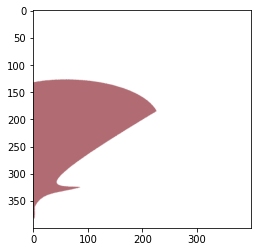

In [79]:
Geometry.render(my_geometries[:1])

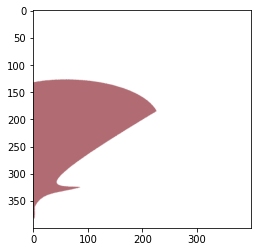

In [80]:
my_render(shapes[:1], shape_groups[:1])

In [81]:
shapes[0].__dict__

{'num_control_points': tensor([2, 2, 2, 2]),
 'points': tensor([[ 87.6202, 325.0495],
         [ 44.0907, 337.1279],
         [ 17.2204, 332.4555],
         [  3.2277, 361.4660],
         [  4.8649, 408.1026],
         [ -3.4114, 396.7335],
         [-39.6997, 143.6361],
         [ 46.0534, 110.3103],
         [196.4756, 130.0354],
         [226.8907, 185.4456],
         [-32.5337, 340.8722],
         [ 46.9929, 319.9378]]),
 'is_closed': True,
 'stroke_width': tensor(0.),
 'id': '',
 'use_distance_approx': False,
 'source_id': ''}

In [82]:
[c.nodes for c in my_geometries[0].poly]

[array([[ 87.62023163,  44.09069824,  17.22042656,   3.22774792],
        [325.04946899, 337.12789917, 332.45547485, 361.46600342]]),
 array([[  3.22774792,   4.8648572 ,  -3.41138983, -39.69971466],
        [361.46600342, 408.1026001 , 396.73348999, 143.63606262]]),
 array([[-39.69971466,  46.05336761, 196.47564697, 226.89071655],
        [143.63606262, 110.3102951 , 130.03540039, 185.4455719 ]]),
 array([[226.89071655, -32.53367996,  46.99290085,  87.62023163],
        [185.4455719 , 340.8722229 , 319.93777466, 325.04946899]])]

In [83]:
# b - transform exact Bezier curves into polygons

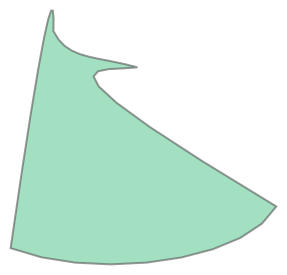

In [84]:
my_geometries[0].to_polygon()

1 1


/tmp/ipykernel_168908/3012239010.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pydiffvg.ShapeGroup(shape_ids=torch.tensor([self.index]), fill_color=torch.tensor(self.color),


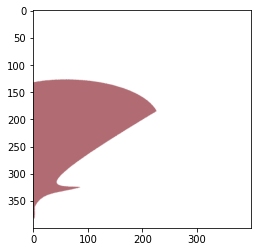

In [85]:
Geometry.render(my_geometries[:1])

/tmp/ipykernel_168908/3012239010.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pydiffvg.ShapeGroup(shape_ids=torch.tensor([self.index]), fill_color=torch.tensor(self.color),


123 123


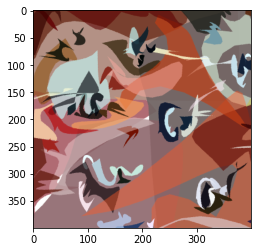

In [86]:
Geometry.poly_render(my_geometries)

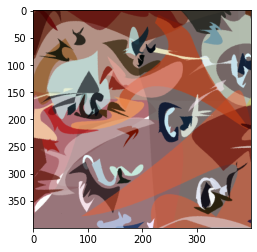

In [87]:
my_render(shapes, shape_groups)

In [88]:
# d - use intersection of polygons

In [89]:
color_polygons = Geometry.to_color_poly(my_geometries)

In [90]:
chunks = ColorPoly.to_chunks(color_polygons)

649 649


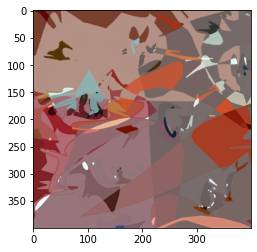

In [91]:
ColorPoly.render(chunks)

In [92]:
len(chunks)

666

In [93]:
# d - color simplification

-40.636798692806885


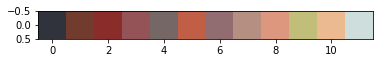

In [94]:

X = [rgb2lab(c.color.numpy()[:3] * c.color.numpy()[3] + (0.8 * np.array([1.0, 1.0, 1.0]) * (1.0 - c.color.numpy()[3])))  for c in chunks]
W = [c.shape.area for c in chunks]


kmeans = KMeans(n_clusters=12, random_state=0, max_iter=10000)
kmeans.fit(X, sample_weight=W)
predicted_kmeans = kmeans.predict(X, sample_weight=W)
print(kmeans.score(X, sample_weight=W) / np.sum(W))

def display_colors(X):
    n_centers, _ = X.shape
    rgb_X = sorted([lab2rgb(X[i, :]) for i in range(n_centers)], key=lambda x: np.sum(x))
    XX = np.concatenate(rgb_X, axis=-1).reshape(-1, 3)
    plt.imshow(XX.reshape(1, -1, 3))
    
display_colors(kmeans.cluster_centers_)

In [95]:
assigned_colors = kmeans.predict(X)

In [96]:
new_chunks = [ColorPoly(c.index, c.shape, 
                        torch.tensor((*lab2rgb(kmeans.cluster_centers_[assigned_colors[i]]).tolist(), 1.0))) 
              for i, c in enumerate(chunks)]
    
    
    

649 649


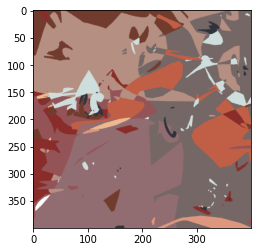

In [97]:
ColorPoly.render(new_chunks)

649 649


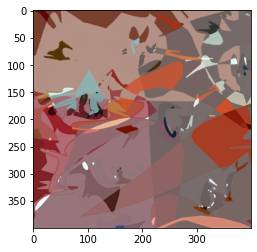

In [98]:
ColorPoly.render(chunks)

In [99]:
from copy import deepcopy
from shapely.geometry import MultiPolygon

def unroll_poly(s):
    polygons = list()
    try:
        for element in s.geoms:
            if element.is_empty or type(element) in [LineString, Point]:
                continue
            polygons.extend(unroll_poly(element))
    except AttributeError:
        polygons.append(s)
    return polygons


def geom_cleaning(shape):
    if type(shape) in [Point, LineString]:
        return Polygon()
    valid_shape = make_valid(shape)
    shapes = unroll_poly(valid_shape)
    return MultiPolygon(shapes)
    


def layer_carving(chunks):
    
    new_chunks = deepcopy(chunks)

    for i in reversed(range(len(new_chunks))):
        layer = make_valid(new_chunks[i].shape)
        for j in range(len(new_chunks)):
            if j < i:
                current_shape = make_valid(new_chunks[j].shape)
                try:
                    new_chunks[j] = ColorPoly(new_chunks[j].index, 
                                              geom_cleaning(current_shape.difference(layer)), 
                                              new_chunks[j].color)
                except Exception as e:
                    print(layer, new_chunks[j].shape)
                    raise e

    new_new_chunks = list()        
    for chunk in new_chunks:
        new_polys = unroll_poly(chunk.shape)
        new_new_chunks.extend([ColorPoly(chunk.index, s, chunk.color) for s in new_polys])
        
    return new_new_chunks



In [100]:
new_new_chunks = layer_carving(new_chunks)

len(new_new_chunks)

481

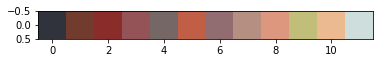

In [101]:
#ColorPoly.render([c for c in new_new_chunks if type(c) == Polygon])
    
display_colors(kmeans.cluster_centers_)

481 481


Text(0.5, 1.0, 'Carved polygons version')

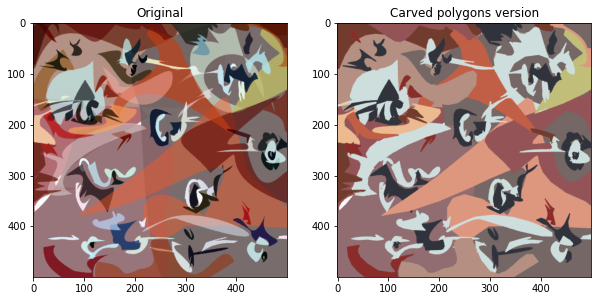

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))


my_render(shapes, shape_groups, ax=axes[0])
axes[0].set_title("Original")
ColorPoly.render(new_new_chunks, ax=axes[1])
axes[1].set_title("Carved polygons version")

In [108]:
render_shapes, render_shape_groups = list(), list()
index = 0
for cp in sorted(new_new_chunks, key=lambda x: x.index):
    if cp.shape.is_empty or type(cp.shape) in [Point, LineString]:
        continue
    s = pydiffvg.Polygon(points=torch.tensor(cp.shape.exterior.coords),
                         stroke_width=torch.tensor(1.0), is_closed=True)
    render_shapes.append(s)
    sg = pydiffvg.ShapeGroup(shape_ids=torch.tensor([index]), fill_color=cp.color, 
                             stroke_color=cp.color, use_even_odd_rule=False)
    render_shape_groups.append(sg)
    index += 1
    
pydiffvg.save_svg("./quantized_carved_version.svg", 500, 500, render_shapes, render_shape_groups)

3 3
1 1
1 1
1 1


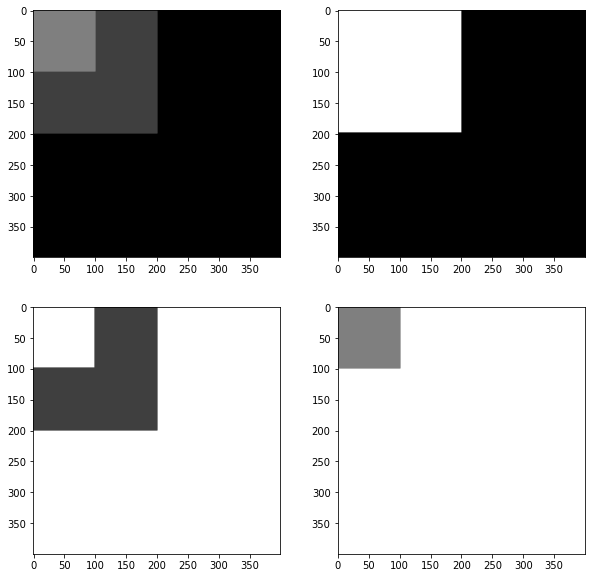

In [103]:
def test_layer_carving():
    scaling = 400
    shape_1 = Polygon([(0, 0), (0, 1.0 * scaling), (1.0 * scaling, 1.0 * scaling), (1.0 * scaling, 0), (0, 0)])
    shape_2 = Polygon([(0, 0), (0, 0.5 * scaling), (0.5 * scaling, 0.5 * scaling), (0.5* scaling, 0), (0, 0)])
    shape_3 = Polygon([(0, 0), (0, 0.25 * scaling), (0.25 * scaling, 0.25 * scaling), (0.25 * scaling, 0), (0, 0)])
    
    chunks = [ColorPoly(i, s, torch.tensor([i * 0.25, i* 0.25, i* 0.25, 1.0])) 
              for i, s in enumerate([shape_1, shape_2, shape_3])]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ColorPoly.render(chunks, axes[0, 0])
    
    carved_chunks = layer_carving(chunks)
    
    ColorPoly.render(carved_chunks[:1], axes[0, 1])
    ColorPoly.render(carved_chunks[1:2], axes[1, 0])
    ColorPoly.render(carved_chunks[2:3], axes[1, 1])
    
test_layer_carving()

In [104]:
str_ = "MULTIPOLYGON (((224.10886007598137 68.25270820418167, 224.1413170767083 68.2672649272337, 224.22808778901725 68.30934733514341, 224.36095388832362 68.37378526863037, 224.57907086905738 68.46860617721826, 224.665004990928 68.5059638899789, 224.6759788343516 68.44877757883434, 224.68908859497674 68.3804606891903, 224.69715195268358 67.81234536532072, 224.6993138251003 67.18395796623359, 224.69930323543946 67.18176037792375, 224.69636317420515 66.57163279129574, 224.69006455141596 65.98296759975047, 224.68218250815056 65.42556015084095, 224.67448159582705 64.90700820381045, 224.6687263658632 64.4349095179022, 224.66668136967687 64.01686185235941, 224.66897750728597 63.77826382675063, 224.61628152101906 64.00098128733921, 224.57365976742082 64.1811204098742, 224.51616262958782 64.4488623109543, 224.4011334012545 64.9845088741486, 224.2590218076769 65.7253459203267, 224.145412030424 66.4034992363323, 224.0583911132312 67.0188365100891, 223.9960460998342 67.5712254295207, 223.9564640339687 68.0605336825509, 223.9377319593703 68.4866289571035, 223.9379369197744 68.849378941102, 223.9551659589168 69.1486513224703, 223.9875061205332 69.3843137891321, 224.0287289513368 69.53994179083149, 224.0330444483589 69.55623402901108, 224.08986798612983 69.66427973003091, 224.15606377758152 69.70831858011536, 224.2163202118089 69.69187473078377, 224.2297188664495 69.6882182671881, 224.3089202964695 69.6038464791729, 224.3481144631621 69.5334517459937, 224.3917551113771 69.45507090399344, 224.47631035490795 69.24175922957346, 224.56067307079758 68.96377914383665, 224.58693962437312 68.85432164969899, 224.6007280898462 68.7968626125112, 224.5530582637412 68.7198607608877, 224.45219979463332 68.6006533567511, 224.34042747172535 68.46854656803988, 224.2215312444214 68.35701126864427, 224.1729777532925 68.3114637496644, 224.0926329933256 68.245430478487, 224.09263299332565 68.24543047848702, 224.09263299332562 68.245430478487, 224.10886007598137 68.25270820418167)), ((224.6890885949768 68.3804606891903, 224.6890885949768 68.38046068918997, 224.68908859497674 68.3804606891903, 224.68908859497674 68.38046068919063, 224.6890885949768 68.3804606891903)));GEOMETRYCOLLECTION (LINESTRING (375.5283081272326 112.23195879691734, 375.5523658650274 112.81620067661262), LINESTRING (375.5523658650274 112.81620067661262, 375.5646256276529 113.11392886793459), LINESTRING (325.0893520565717 43.669019643317924, 324.3830317625862 42.59254032679162), LINESTRING (306.20739015271903 86.8579158732031, 306.9227549645864 88.35459167103205), LINESTRING (322.74920451069823 88.98526837759566, 316.512451659876 88.86664098678389), LINESTRING (307.89993161908427 90.3043970666034, 307.54996573282267 90.32192298857564), LINESTRING (304.1959572368611 88.2752123185202, 306.9629832060612 88.43486092625932), LINESTRING (306.9629832060612 88.43486092625932, 310.2593154503687 88.62504882449628), LINESTRING (220.2614066147947 77.1731965842405, 221.6204731235147 75.86999024843944), LINESTRING (299.33592584825226 161.42087240276484, 300.017278043198 158.988246123941), LINESTRING (303.4133121198203 162.67774314620712, 305.86459318553057 160.9604664827225), LINESTRING (337.52454295181224 141.92527520605944, 337.008227674952 141.2664001144515), LINESTRING (307.89901376614137 165.8337238418576, 309.9652715379 164.0442163982858), LINESTRING (258.27083672202036 33.17638879242875, 258.1506575042665 33.08603578708978), LINESTRING (247.15932090505933 73.73295676590956, 250.05006995606414 74.22477533849649), LINESTRING (224.22664154653745 72.69995121023854, 224.15648056794186 72.93700176869193), LINESTRING (224.60072808984623 68.79686261251118, 224.64293030278162 68.62099833470673), LINESTRING (224.64293030278162 68.62099833470673, 224.66500499092803 68.50596388997893), LINESTRING (375.5646256276529 113.11392886793459, 375.5906711280446 113.74644353894189), POLYGON ((377.05303252417633 18.717074105647118, 376.66931489940316 8.950865327810888, 375.9054052679628 -3.6774806727897484, 360.37360110269793 -0.1109467526390056, 359.4225293015068 0.1343371410325502, 360.69443413080126 1.6224711175246203, 362.1778422207101 3.6942684980349654, 363.21282784805567 5.531931429469641, 363.8017537483279 7.092542328768648, 363.9469826570164 8.333183612871974, 363.6508773096109 9.210937698719622, 362.9158004416013 9.68288700325159, 361.7441147884773 9.706113943407871, 360.13818308572843 9.237700936128459, 358.1003680688448 8.234730398353358, 355.6330324733158 6.654284747022562, 352.7385390346314 4.453446399076066, 350.4229337499395 2.455356264502546, 350.14981775983694 2.5257935894157835, 350.8048701074575 3.4512371344341304, 351.4013418564962 4.383023673461917, 351.9344661030226 5.307889454166037, 352.40490125042766 6.220235479034921, 352.8133057021016 7.114462750556994, 353.160337861435 7.9849722712206805, 353.44665613181866 8.826165043514413, 353.6729189166431 9.632442069926617, 353.8397846192987 10.398204352945717, 353.94791164317644 11.117852895060139, 353.99795839166666 11.785788698758317, 353.99058326815975 12.39641276652867, 353.9264446760467 12.944126100859629, 353.8062010187178 13.423329704239624, 353.63051069956373 13.828424579157073, 353.4000321219751 14.15381172810041, 353.1154236893425 14.393892153558063, 352.77734380505655 14.543066858018456, 352.3864508725077 14.595736843970014, 351.9434032950866 14.546303113901171, 351.4488594761838 14.389166670300344, 350.90347781919013 14.11872851565597, 350.3079167274958 13.72938965245647, 349.6628346044916 13.215551083190274, 348.9688898535681 12.571613810345806, 348.22674087811583 11.791978836411495, 347.4370460815255 10.87104716387577, 346.6004638671875 9.80321979522705, 346.03708781286525 9.136301510350343, 345.60679847253994 8.91739004591577, 345.2866438245846 9.110148682845145, 345.0536718473716 9.678240702060261, 344.88493051927395 10.585329384482934, 344.9255023243783 10.367230915954348, 345.03017268532193 10.421796549778641, 345.65425265710775 10.871301335129843, 346.55198654105357 11.551663329882924, 347.7027443367263 12.416160714724558, 349.0858960436926 13.418071670341407, 350.6808116615192 14.51067437742013, 352.46686118977294 15.647247016647409, 354.4234146280205 16.781067768709896, 356.5298419758287 17.86541481429426, 358.76551323276425 18.85356633408717, 361.1097983983939 19.698800508775285, 363.5420674722844 20.35439551904528, 366.0416904540025 20.773629545583816, 368.58803734311493 20.90978076907755, 371.1604781391886 20.71612737021317, 373.7383828417901 20.14594752967732, 376.3011214504862 19.152519428156673, 377.05303252417633 18.717074105647118), (344.88493051927395 10.585329384482934, 344.9255023243783 10.367230915954341, 344.9255023243783 10.367230915954345, 344.88493051927395 10.585329384482934)), POLYGON ((320.2995753913975 43.94801663885307, 319.6524269654256 43.95785492609981, 315.53061227283484 43.590091428817715, 310.96808375355806 42.761916775022854, 305.94188938596807 41.436994245637024, 300.4290771484375 39.57898712158203, 296.55213977460704 33.401278380162076, 292.93438417892264 27.873651457202403, 289.56797037066366 22.95445551280435, 288.1415258633218 20.966413711822504, 280.1504455358177 23.998495888904344, 279.45344077916627 24.828784898519178, 275.4743377280131 28.26906020660194, 273.22614517603216 29.805127001503834, 271.74282976056895 28.700360920788093, 275.02625616352725 31.145840877849068, 277.8912794681007 33.42708181745427, 280.380889135551 35.580882024626206, 282.53807462713934 37.64403978438732, 284.4058254041268 39.65335338176008, 286.02713092777526 41.645621101766984, 287.44498065934573 43.65764122943049, 288.7023640600995 45.72621204977307, 289.8422705912982 47.8881318478172, 290.9076897142031 50.18019890858535, 291.9416108900753 52.639211517099994, 292.98702358017647 55.301967958383614, 294.08691724576784 58.20526651745867, 295.2842813481107 61.38590547934763, 296.62210534846645 64.88068312907296, 298.1433787080966 68.72639775165719, 299.8910908882623 72.95984763212273, 301.90823135022487 77.61783105549209, 304.23778955524585 82.73714630678771, 306.20739015271903 86.8579158732031, 307.49074849277275 86.47396203140046, 315.45880126953125 83.99166107177734, 310.2388041227971 85.61785561260209, 309.4390278959769 79.8375730792546, 309.16604465229824 71.7832301823463, 309.83665012905647 64.23957278052106, 311.4997046080124 57.33213929951306, 314.20406837092685 51.186468165056404, 317.9986016995607 45.92809780288522, 320.2995753913975 43.94801663885307), (271.74282976056895 28.700360920788093, 273.22614517603216 29.805127001503838, 273.22614517603216 29.80512700150384, 271.74282976056895 28.700360920788093)), POLYGON ((373.44013310178696 127.61805836837364, 373.2694586980211 126.91132029840301, 373.0471861281417 126.19911855276652, 373.2694586980211 126.91132029840303, 373.44013310178696 127.61805836837364)), POLYGON ((371.90787704275704 123.99714661176327, 371.31630942935783 123.2305055133648, 370.59169246031206 122.44210841425124, 371.31630942935783 123.23050551336482, 371.90787704275704 123.99714661176327)), POLYGON ((367.45664304022944 119.91379646252157, 366.03692626953125 119.00579071044922, 365.1968482953361 115.91310100922205, 366.03692626953125 119.00579071044923, 367.45664304022944 119.91379646252157)), POLYGON ((360.4464355904197 98.46346743900921, 357.0078427635674 98.35245225839037, 355.4078565977051 98.32954201239616, 357.0078427635674 98.3524522583904, 359.30034648181055 98.42646588174313, 360.4464355904197 98.46346743900921)), POLYGON ((345.05244342382116 98.50652356745842, 340.5810787096602 98.83772266257648, 335.8967525377852 99.36757760796922, 337.188087563101 99.2215117226706, 340.5810787096602 98.8377226625765, 343.2038822945549 98.64344860319626, 345.05244342382116 98.50652356745842)), POLYGON ((337.188087563101 99.2215117226706, 336.34778523365947 104.94024101193823, 336.92768532214427 112.4239125110023, 339.3104183493107 120.06074457701547, 338.9893408491961 119.03166791563784, 336.9276853221443 112.4239125110023, 336.3477852336595 104.9402410119382, 337.188087563101 99.2215117226706)), POLYGON ((346.22868192859255 130.777827107034, 346.146402820029 130.80859043284477, 348.4437696186397 129.94962824224334, 346.22868192859255 130.777827107034)), POLYGON ((349.961303458178 134.51090267412414, 349.4094760604947 135.52026022708873, 349.739461724587 134.9166774332298, 349.739461724587 134.91667743322984, 349.961303458178 134.51090267412414)), POLYGON ((350.1289929552582 135.37589491618516, 352.5321645156469 137.42542203630776, 352.48695546010293 137.3868658271133, 350.1289929552582 135.37589491618516)), POLYGON ((352.5321645156469 137.42542203630776, 358.88713940182436 142.84521544248963, 370.09272852264223 150.04970104203923, 370.1368896659199 150.07155163509154, 370.1148090942811 150.06062633856538, 370.0927285226423 150.0497010420392, 358.8871394018244 142.8452154424896, 352.5321645156469 137.42542203630776)), POLYGON ((373.60568128286525 148.05016004980072, 377.4295533485355 147.20200562339272, 379.07546201809544 147.72844416298815, 377.4295533485355 147.2020056233927, 373.6056812828653 148.0501600498007, 373.60568128286525 148.05016004980072)), POLYGON ((315.18469939270966 104.25590296598702, 315.18469939270966 104.25590296598703, 315.03686247990464 103.98551153866651, 315.07105909803334 104.04805662439591, 315.0027740593496 103.92316434462619, 317.5399890311398 108.56369129168237, 315.18469939270966 104.25590296598702)), POLYGON ((313.5308652412721 101.23106587845695, 314.9543457547164 103.83458972436382, 314.99571081308034 103.91024577642813, 313.5308652412721 101.23106587845695)), POLYGON ((350.2425098092353 158.11073354896868, 354.6576006274975 163.50564187618858, 350.2425098092354 158.1107335489688, 353.3169779694043 160.8502506163978, 354.4857736510962 161.69782871807553, 353.3169779694043 160.85025061639774, 350.2425098092353 158.11073354896868)), POLYGON ((364.0945432430616 92.10238097271137, 364.49747432974794 89.71052032643381, 364.18610890146897 91.55883319957665, 364.18610890146897 91.55883319957664, 364.0945432430616 92.10238097271137)), POLYGON ((373.4820250889253 91.26237189392894, 373.7036118205844 92.63201249908481, 374.26456737178114 93.41341864904837, 375.1587372007608 94.99368949438735, 374.82632666368886 94.40621867688311, 374.2645673717812 93.4134186490484, 373.7036118205844 92.63201249908474, 373.4820250889253 91.26237189392894)), POLYGON ((375.5685564873476 96.24400250195839, 375.51211783718696 97.19959858429769, 375.00751385592395 97.8957186539414, 374.4721841468929 98.16598755183291, 374.4721841468929 98.16598755183296, 375.007513855924 97.8957186539414, 375.512117837187 97.1995985842977, 375.5685564873476 96.2440025019584, 375.5685564873476 96.24400250195839)), POLYGON ((375.5283081272326 112.23195879691734, 376.93951198667514 105.7719201833209, 375.5283081272326 112.23195879691731, 375.5283081272326 112.23195879691734)), POLYGON ((378.4335499087443 99.1529101905477, 378.9572147391859 96.93696878099205, 378.9572147391859 96.93696878099195, 378.4335499087443 99.1529101905477)), POLYGON ((378.43983401084876 62.92939012544108, 378.43983401084876 62.92939012544105, 377.2722782512117 63.12451424071396, 369.2310024503755 65.62094176084902, 371.22561578378605 65.00171071581552, 377.2722782512117 63.124514240714, 378.43983401084876 62.92939012544108)), POLYGON ((361.7033401170806 69.10652083534123, 354.85044368521955 73.47675259076459, 348.8334655886847 78.62713815369305, 343.81355826136877 84.45317865070065, 339.9518741371642 90.8503752083614, 343.8135582613688 84.4531786507007, 348.8334655886847 78.6271381536931, 354.8504436852196 73.4767525907646, 359.23494485626225 70.68066681303485, 361.7033401170806 69.10652083534123)), POLYGON ((339.1168817386176 98.13936374868734, 342.2332872083166 97.69066339366341, 345.7751337638166 96.99401144457605, 342.94040498353127 97.5515791706124, 342.2332872083166 97.6906633936634, 341.6095377167611 97.78047090460132, 339.1168817386176 98.13936374868734)), POLYGON ((344.87212449959003 10.706871330872401, 344.75746781866394 11.795078011034962, 344.6483317239145 13.271149862638142, 344.5345702133983 14.97720822021429, 344.393231265488 16.876916364685208, 344.2013628585561 18.93393757697269, 343.93601297097547 21.111935137998543, 343.5742295811189 23.374572328684586, 343.0930606673587 25.685512429952592, 342.4695542080678 28.00841872272439, 341.68075818161896 30.306954487921782, 341.2119774037141 31.380660328294617, 341.3971461080587 31.570673854154848, 342.1322679259621 32.38318936499954, 342.8423683579115 33.23067764452089, 343.5254462621148 34.113574318039426, 344.17950049678 35.03231501087569, 344.8025299201148 35.9873353483502, 345.39253339032723 36.97907095578349, 344.97810713182093 36.282462718770795, 345.0556363065068 36.27839259173803, 355.03392169015024 37.339602477006295, 366.3955383300781 40.041343688964844, 362.1266313221501 34.07626005505337, 358.37893823158095 28.90269546230378, 355.13182905793775 24.473928091402758, 352.3646738007869 20.743236123036958, 350.0568424596954 17.66389773789306, 348.18770503423 15.189191116657716, 346.7366315239572 13.272394440017594, 345.68299192844404 11.866785888659361, 345.0061562472573 10.925643643269686, 344.87212449959003 10.706871330872401)), POLYGON ((345.947509765625 38.007957458496094, 342.1827860032996 35.736571723662394, 339.70854880709504 34.337740710068175, 339.5154893407376 34.68556755928053, 338.12921791695817 36.6420157418845, 343.2389098344649 36.37376710791152, 345.947509765625 38.007957458496094)), POLYGON ((309.41029268239373 93.31808976683979, 310.00611703950807 94.50696543324767, 313.5308652412721 101.23106587845695, 310.45892283688505 95.37077512672083, 310.45892283688505 95.37077512672079, 310.61201409919363 94.470050957073, 310.45892283688505 95.37077512672072, 310.0061170395081 94.5069654332477, 309.41029268239373 93.31808976683979)), POLYGON ((310.42445735957926 92.46466607856546, 310.4222421906933 92.44098115955666, 309.69016435512026 90.8254632860284, 310.2365798515272 92.03126949668535, 310.4222421906933 92.4409811595567, 310.42445735957926 92.46466607856546)), POLYGON ((231.81722491791174 79.26597769268521, 228.10306667787884 78.58659193650584, 224.14680974901597 77.87021376664428, 220.2614066147947 77.1731965842405, 220.17502158578407 77.25603102714871, 218.80566630542748 78.23237324445283, 217.51250620399372 78.83171049666494, 216.29564020303184 79.08673638009836, 215.15516722409058 79.03014449106625, 214.09118618871886 78.69462842588186, 213.10379601846574 78.11288178085846, 212.19309563488 77.31759815230924, 211.3591839595105 76.34147113654743, 210.60215991390618 75.2171943298863, 209.92212241961613 73.97746132863904, 209.319170398189 72.65496572911889, 208.7934027711738 71.28240112763908, 208.34491846011943 69.89246112051288, 207.97381638657475 68.51783930405348, 207.7099188375202 67.32552255119649, 205.04040460337467 70.38260892672294, 200.28750622926972 77.57833371926284, 200.28320400093463 77.58750641430217, 201.8251472262616 77.83583989558447, 204.32369995117188 78.03292846679688, 203.54204748363983 78.60217653534414, 202.80652144890857 79.0449982828122, 202.11357585930912 79.37387188254475, 201.4596647271723 79.60127550788536, 200.84124206482906 79.73968733217772, 200.25476188461028 79.80158552876543, 199.6966781988468 79.79944827099204, 199.2660833521432 79.756089019147, 198.20598655427187 82.01630021242785, 198.39810972789724 81.99586015019578, 199.11227407670114 81.98373282733372, 199.84559473435553 82.0251331926052, 200.58339263566907 82.11333578191778, 201.31098871545072 82.24161513117906, 202.0137039085093 82.40324577629661, 202.6768591496537 82.59150225317802, 203.28577537369262 82.79965909773087, 203.825773515435 83.02099084586274, 204.28217450968967 83.24877203348119, 204.64029929126545 83.47627719649384, 204.88546879497116 83.69678087080824, 205.0030039556157 83.90355759233199, 204.9782257080078 84.08988189697266, 204.56292566196757 84.83944686976612, 204.20994904466627 85.5935394723182, 203.91260496124906 86.35121381987143, 203.66420251686068 87.11152402766834, 203.45805081664636 87.87352421095147, 203.28745896575091 88.63626848496344, 203.1457360693193 89.39881096494665, 203.02619123249661 90.16020576614379, 202.92213356042782 90.91950700379732, 202.82687215825777 91.6757687931498, 202.7337161311316 92.42804524944377, 202.6359745841942 93.1753904879218, 202.52695662259052 93.91685862382637, 202.39997135146555 94.65150377240009, 202.24832787596438 95.3783800488855, 202.0653353012318 96.09654156852508, 201.84430273241296 96.80504244656142, 201.5785392746528 97.5029367982371, 201.26135403309618 98.18927873879458, 200.88605611288824 98.86312238347648, 200.44595461917388 99.5235218475253, 199.93435865709802 100.1695312461836, 199.34457733180574 100.80020469469389, 198.669919748442 101.41459630829875, 197.90369501215167 102.01176020224071, 197.0392122280799 102.59075049176232, 196.0697805013715 103.15062129210614, 194.98870893717157 103.69042671851467, 193.789306640625 104.20922088623047, 193.61518531168917 104.02880358352968, 193.574645682647 106.34815376447845, 193.65168766304765 107.17622995420349, 194.76536560058594 107.59304809570312, 200.29152303776468 104.09546967660123, 205.36331997913274 101.10427387401309, 209.9900483684281 98.59284315219132, 214.18100014938832 96.53455997538832, 217.94546726575132 94.90280680785669, 221.2927416612548 93.67096611384883, 224.23211527963645 92.8124203576173, 226.77288006463417 92.30055200341462, 228.92432795998565 92.10874351549327, 230.6957509094286 92.21037735810573, 232.09644085670087 92.57883599550453, 233.13568974554022 93.18750189194222, 233.82278951968436 94.0097575116712, 233.93403742196656 94.33590678966479, 231.17048719721217 97.13441632767532, 236.39318199678561 91.84565367744224, 240.86153944568338 86.34700414495003, 243.86191723388214 81.53221268100566, 241.58094325185462 81.09330945369028, 238.5487796302172 80.51822355382141, 235.29666804379704 79.90948393263838, 231.81722491791174 79.26597769268521)), POLYGON ((195.42423890351284 119.9471525775461, 195.55288593746297 120.64703891551912, 195.84825509068006 121.80598518143215, 195.552885937463 120.6470389155191, 195.4242389035129 119.9471525775461, 198.099874363902 118.90012890507882, 201.2515171020838 117.04718971275912, 204.506332397461 114.494140625, 205.20615966096554 114.37640538266146, 204.50633239746094 114.494140625, 201.25151710208382 117.04718971275905, 198.09987436390196 118.9001289050788, 195.42423890351284 119.9471525775461)), POLYGON ((210.40062482872102 113.34591410001585, 210.40062482872116 113.34591410001575, 208.18991411010387 113.87443429426914, 208.97209818002096 113.68743557340844, 210.40062482872102 113.34591410001585)), POLYGON ((234.59918444503384 157.90284506963465, 228.74254197764253 159.55285322919846, 222.88361913430856 160.49656706463588, 217.05194968071422 160.7953863220953, 211.2770673825422 160.51071074772517, 207.99985742028252 160.0459259508102, 208.80638544241472 162.6635213056816, 209.5383667126875 165.5261402285314, 218.54761670390354 165.759508726278, 253.85126730174647 166.42318067378997, 292.28189183435023 166.90731171241148, 297.9036344618911 166.94750847618533, 298.1292135341956 166.03430257427567, 299.11788905143464 162.19932743031688, 299.33592584825226 161.42087240276484, 295.3863072450655 159.38549914675409, 281.6899390100402 153.11741655607733, 267.946140730228 147.7782543454058, 256.14394520863544 144.17443738520717, 251.86009193472648 148.101057184701, 246.18749318925833 152.23834679353436, 240.42401277080003 155.48514283979617, 234.59918444503384 157.90284506963465)), POLYGON ((306.5416646563688 167.0092723957034, 310.1136363345351 167.03481282173618, 308.86460476116366 166.33132583459874, 307.89901376614137 165.8337238418576, 306.5416646563688 167.0092723957034)), POLYGON ((212.0457918574642 68.57727566185342, 212.85121917380505 69.19657091887372, 213.5961135894914 69.68577447864878, 213.43498693785372 69.57995581509608, 212.8512191738051 69.1965709188737, 212.0457918574642 68.5772756618534, 211.1755675969223 67.8201105343889, 211.17244712008062 67.81711122443708, 211.17556759692232 67.82011053438893, 212.0457918574642 68.57727566185342)), POLYGON ((214.02251588745673 69.91295564029244, 214.28473914806983 70.05266451437762, 214.92135989308687 70.30501919925919, 214.82814535883816 70.26806921828411, 214.2847391480698 70.0526645143776, 214.02251588745673 69.91295564029244)), POLYGON ((215.51023986808895 70.45061670649245, 216.0556431166228 70.49723520927644, 216.56183368223486 70.45265288081009, 216.41928122824967 70.46520807397053, 216.0556431166228 70.4972352092764, 215.7664477904768 70.47251615387422, 215.51023986808895 70.45061670649245)), POLYGON ((218.4864791255014 69.30571947023473, 218.65383779059732 69.13396483168762, 218.77977645334113 68.9842728595655, 218.6538377905973 69.1339648316876, 218.4864791255014 69.30571947023473)), POLYGON ((219.7113868475322 67.74614511194487, 220.05654522644264 67.23077309617962, 220.40513135789678 66.70198198115382, 220.28829223904373 66.87922221638406, 220.0565452264426 67.2307730961796, 219.82665733736698 67.5740293867177, 219.7113868475322 67.74614511194487)), POLYGON ((221.1296430526221 65.63525514611655, 221.51409670298642 65.11287577250302, 221.91903428008055 64.60818999242487, 221.64906036622176 64.94466653356073, 221.5140967029864 65.112875772503, 221.32895658103678 65.36443634643211, 221.1296430526221 65.63525514611655)), POLYGON ((222.34871982745108 64.12897597908109, 222.80741738864447 63.68301190567064, 223.29939100720736 63.2780759453925, 223.06806288973897 63.46847858051758, 222.8074173886445 63.68301190567059, 222.64880437197826 63.83722180995779, 222.34871982745108 64.12897597908109)), POLYGON ((224.7089156166029 62.50480976618545, 225.0176086425781 62.38721847534181, 225.0176086425781 62.3872184753418, 224.7089156166029 62.50480976618545)), POLYGON ((225.01760864257812 62.3872184753418, 224.83785562111174 63.084965896183895, 224.83785562111177 63.08496589618381, 224.8378556211118 63.084965896183895, 224.9576979586853 62.61977381614276, 225.01760864257812 62.3872184753418)), POLYGON ((224.8378556211118 63.084965896183895, 224.83785562111177 63.084965896183974, 224.87250958326055 63.16673899590378, 224.8378556211118 63.084965896183895)), POLYGON ((224.99908905110632 64.39599820138237, 224.98513298186387 65.1960888124, 224.9556807348652 65.93045251549056, 224.91264526637465 66.59922162273028, 224.85793953265667 67.20252844619547, 224.79347648997555 67.74050529796243, 224.75330106961988 68.00319077681361, 224.7934764899756 67.7405052979624, 224.8579395326567 67.2025284461955, 224.9126452663747 66.5992216227303, 224.9556807348652 65.9304525154906, 224.9851329818639 65.1960888124, 224.99217236863066 64.79252623603396, 224.99908905110632 64.39599820138237)), POLYGON ((224.75330106961988 68.00319077681361, 224.72116909459572 68.21328449010741, 224.7477926980076 68.039207057959, 224.75330106961988 68.00319077681361)), POLYGON ((224.72116909459572 68.21328449010741, 224.68908859497674 68.3804606891903, 224.68811300553696 68.44919722931397, 224.68732866619717 68.47748747497279, 224.688113005537 68.449197229314, 224.6890885949768 68.3804606891903, 224.7098127679691 68.2724639774449, 224.72116909459572 68.21328449010741)), POLYGON ((224.68732866619717 68.47748747497279, 224.68628271280082 68.51521384802379, 224.68727876901198 68.47928721082114, 224.68732866619717 68.47748747497279)), POLYGON ((224.7934673130549 68.56180967540288, 225.48078123578537 68.82815632027713, 226.4648195413984 69.16964337597904, 227.7875061147772 69.58308901523448, 227.12616282808779 69.37636619560675, 226.4648195413984 69.169643375979, 225.4807812357854 68.8281563202771, 224.97551751811545 68.63235744071501, 224.7934673130549 68.56180967540288)), POLYGON ((228.35153968013267 69.74277680246931, 229.49076484080496 70.06531141076934, 231.6165196043651 70.61312873530952, 234.20669429034066 71.2233591615809, 237.30321278361515 71.8928208623094, 240.9479989690717 72.61833201022091, 245.18297673159358 73.3967107780413, 245.315888932535 73.41932384053582, 245.1829767315936 73.3967107780413, 240.9479989690717 72.6183320102209, 237.30321278361524 71.8928208623094, 234.20669429034072 71.2233591615809, 231.6165196043651 70.6131287353095, 229.490764840805 70.0653114107693, 228.35153968013267 69.74277680246931)), POLYGON ((248.31863135858248 68.35901661310997, 248.3476830750375 61.788101910772525, 246.9114192759469 54.89094150577155, 243.86764432833672 47.644263634026146, 240.3197568064905 42.00472774256833, 240.3197568064905 42.004727742568335, 242.2080421872374 45.006247129094945, 243.8676443283367 47.6442636340261, 246.9114192759469 54.8909415057716, 248.34768307503748 61.78810191077249, 248.3379780115602 63.98319232440702, 248.31863135858248 68.35901661310997)), POLYGON ((242.2080421872374 45.006247129094945, 236.61535713101642 47.158482386522465, 226.56716554992983 50.67058479248607, 219.25810585739896 56.02632430246031, 215.13775332009124 59.7459797390581, 219.258105857399 56.0263243024603, 226.5671655499299 50.6705847924861, 236.6153571310164 47.1584823865225, 238.377280268647 46.480440791194695, 242.2080421872374 45.006247129094945)), POLYGON ((210.7074751082752 63.892767513599885, 209.60562428165576 65.15459002304192, 210.2362823486328 66.91729736328125, 209.99498542427713 66.24286555623608, 209.6056242816558 65.1545900230419, 210.7074751082752 63.892767513599885)), POLYGON ((210.2362823486328 66.91729736328125, 211.17244712008062 67.81711122443708, 211.15783619172498 67.80306763268942, 210.2362823486328 66.91729736328125)), POLYGON ((225.0427982324535 70.07100985900585, 224.94616752898858 69.51791057909658, 224.7689462444568 69.0685881554819, 224.675141530793 68.91706386363293, 224.67043243224265 69.0869157989701, 224.64234568138266 69.71790331504585, 224.60208820153917 70.334562018298, 224.54789544129423 70.92929414948334, 224.47800284922988 71.49450194935864, 224.39064587392832 72.02258765868065, 224.28405996397163 72.50595351820616, 224.22664154653745 72.69995121023854, 224.4299080076143 72.38478710924235, 224.8265923566496 71.50126629680464, 225.0169144699683 70.73106782248385, 225.0427982324535 70.07100985900585)), POLYGON ((222.34430739774152 75.00010730296877, 222.84975706286042 74.50452305756497, 223.25702107848565 74.0168974084889, 223.1419219970703 74.04155731201172, 222.34430739774152 75.00010730296877)), POLYGON ((224.6807802843087 63.37331061934316, 224.670111158686 63.66046296642531, 224.6807802843087 63.37331061934321, 224.7004532979626 63.1630025703561, 224.7199332188373 63.08245912356881, 224.70045329796255 63.16300257035612, 224.6807802843087 63.37331061934316)), POLYGON ((224.670111158686 63.66046296642531, 224.66897750728597 63.778263826750475, 224.77851386244066 63.31531283957986, 224.668977507286 63.77826382675035, 224.670111158686 63.66046296642531)), POLYGON ((224.83785562111174 63.084965896183895, 224.83114118129103 63.06912180439828, 224.7738691950359 63.003310403640455, 224.73089475106562 63.037136578707475, 224.72803042414364 63.04897968446267, 224.73089475106562 63.03713657870749, 224.7738691950359 63.0033104036405, 224.831141181291 63.0691218043983, 224.8338081403676 63.0754150389087, 224.83785562111174 63.084965896183895)), POLYGON ((224.60072808984623 68.79686261251118, 224.55305826374124 68.71986076088768, 224.34042747172535 68.46854656803988, 224.17297775329249 68.31146374966436, 224.09263299332562 68.245430478487, 224.14131707670825 68.2672649272337, 224.36095388832362 68.37378526863037, 224.66500499092803 68.50596388997893, 224.68908859497674 68.3804606891903, 224.69715195268358 67.81234536532072, 224.6993138251003 67.18395796623356, 224.69636317420515 66.57163279129574, 224.69006455141596 65.98296759975047, 224.68218250815056 65.42556015084095, 224.67448159582705 64.90700820381045, 224.6687263658632 64.4349095179022, 224.66668136967687 64.01686185235941, 224.66897750728597 63.778263826750475, 224.57365976742082 64.1811204098742, 224.40113340125444 64.9845088741486, 224.25902180767687 65.72534592032672, 224.14541203042396 66.40349923633231, 224.05839111323118 67.01883651008905, 223.99604609983416 67.57122542952065, 223.9564640339687 68.0605336825509, 223.93773195937024 68.48662895710346, 223.93793691977436 68.84937894110203, 223.95516595891678 69.14865132247034, 223.98750612053317 69.38431378913212, 224.0330444483589 69.55623402901108, 224.08986798612983 69.66427973003091, 224.15606377758152 69.70831858011536, 224.22971886644953 69.6882182671881, 224.30892029646952 69.6038464791729, 224.3917551113771 69.45507090399344, 224.47631035490795 69.24175922957346, 224.56067307079758 68.96377914383665, 224.60072808984623 68.79686261251118)), POLYGON ((375.8822937011719 124.28651428222656, 378.56214339517385 124.02891714080508, 379.1520398152431 123.90686929673672, 379.1520398152431 123.9068692967367, 378.56214339517385 124.02891714080506, 375.8822937011719 124.28651428222656)), POLYGON ((379.1110242605666 115.51691560988668, 379.1110242605666 115.51691560988661, 379.0578743452379 115.49166593802285, 375.5906711280446 113.74644353894189, 375.5906711280446 113.74644353894193, 379.0578743452379 115.4916659380229, 379.1110242605666 115.51691560988668)), POLYGON ((199.9661658878789 93.17440815199504, 198.63149778098702 91.55230981603974, 197.5361719608131 90.08462112960432, 196.66550936216578 88.76461662859624, 196.04946589939541 87.665226367983, 195.3444296448009 90.0290255870225, 195.57352834625914 90.21158082134546, 196.48412839622142 90.93969039106786, 197.52942089731638 91.77474967358742, 198.7175460734722 92.7203602492675, 200.0566441486172 93.78012369847141, 201.5548553466797 94.9576416015625, 199.9661658878789 93.17440815199504)), POLYGON ((194.67929426632205 100.11077804875123, 194.59845377871108 99.51519684516086, 194.39893702779528 98.76591713708376, 194.06813912139646 97.84912583017473, 193.93930791322 97.55109256025058, 193.70013219708324 99.16882882143057, 193.66360537347913 101.2585986821151, 193.744523981038 101.2666648014811, 194.0679914272796 101.23237970514762, 194.33580707110693 101.11346157605303, 194.53536602034183 100.89609731985216, 194.65406338280627 100.56647384219994, 194.67929426632205 100.11077804875123)))"

len(str_.split(";"))



2

In [105]:
shape_a = wkt.loads(str_.split(";")[0])
shape_a

NameError: name 'wkt' is not defined

In [ ]:
shape_b = wkt.loads(str_.split(";")[1])
shape_b

In [ ]:
shape_b.geoms